# Multi-Armed Bandits

### Objective

 * Define the difference between exploitation and exploration
 * Explain how multi-armed bandit addresses the trade-off between exploitation and exploration.
 * Measure the regret of a strategy.
 * Introduce and implement the multi-armed bandit algorithm(s).

In [3]:
import numpy as np
import random
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## The Multi-Armed Bandit

The multi-armed bandit is a mathematical problem. Suppose we have two or more slot machines, and each slot machine (a.k.a. one-armed bandit) has a different (unknown!) chance of winning. What strategy should we follow to maximize our payoff after a finite number of plays.

In this case we're assuming they all have the same payoff ("binary bandits") but there are many version of this problem.

In reality these might be drugs, or web-site designs, or ad campaigns, or job-search strategies, or dating profiles, or anything where we want to exploit the "winner" of our hypothesis testing.

![](img/intro_mulit_armed_bandit.jpg)



### A Hypothetical A/B Test

Let's say Galvanize wants me to change the color of the company website to see how that affects recruitment into the DSI program. I'm unsure what to do so I consult my two friends, Dora and Jonah.

<img src='img/color_webpage.png' width=600>

#### Dora the Scientist

Dora proposes I run an A/B test. 

##### Review: A/B Testing

> What is A/B Testing? 

In Dora’s proposed A/B testing setup, groups A and B of users would see slightly different colored versions of the same website. After enough users had been exposed to both designs, comparisons between the two groups would allow me to decide whether the proposed change would help or hurt the site.

Once I was convinced of the merits of A/B testing, I started to contemplate much larger scale experiments: instead of running an A/B test, I could run a A/B/C/D/E/F/G test including quirky colors I find interesting.

Running careful experiments about each of these ideas excited Dora as a scientist, but I worry that some of the colors that Dora had proposed testing seemed likely to be much worse than the current color. 

Dora represents the idea of `exploration`.

<img src='img/doras_plan.png' width=600 >

**Exploration**:
An algorithm for solving the Multi-Armed Bandit Problem explores if it plays any arm that does not have the highest estimated value based on previous plays.

Unsure what to do, I raised my concern with my friend Jonah, who worked at a large multinational bank.



#### Jonah the Businessman

Jonah heard of my idea of testing out several new logo colors on the site and agreed that experimentation could be profitable. But Jonah was also very skeptical about the value of trying out some of the quirkier colors that Dora suggested.

"Dora’s a scientist. Of course she thinks that you should run lots of experiments. She wants to have knowledge for knowledge’s sake and never thinks about the costs of her experiments. But you’re a data scientist. You have a livelihood to make. You should try to maximize your site’s profits. To keep your checkbook safe, you should only run experiments that could be profitable. Knowledge is only valuable for profit’s sake in business. Unless you really believe a change has the potential to be valuable, don’t try it at all. And if you don’t have any new ideas that you have faith in, going with your traditional color is the best strategy."

Jonah represents the idea of `exploitation`.

<img src='img/jonahs_plan.png' width=600>

**Exploitation**: An algorithm for solving the Multiarmed Bandit Problem exploits if it plays the arm with the highest estimated value based on previous plays.

Jonah’s skepticism of the value of large-scale experimentation rekindled my earlier concerns: the threat of losing customers was greater than I had previously felt when energized by Dora’s passion for designing experiments. 

## Explore-Exploit Dilemna 
<i><b>Trade-Offs:</b> Is there room for Dora and Jonah to compromise and create a solution that is better than either?</i>

After spending some time weighing Dora and Jonah’s arguments, I decided that there was always going to be a fundamental trade-off between the goals that motivated Dora and Jonah: a small business couldn’t afford to behave like a scientist and spend money gaining knowledge for knowledge’s sake, but it also couldn’t afford to focus short-sightedly on current profits and to never try out any new ideas. As far as I could see, there was never going to be a simple way to balance the need to (1) learn new things and (2) profit from old things that she’d already learned.

This represents something called the `explore-exploit dilemma`. We need to figure out A/B testing algorithms that will allow us to explore new options while also exploiting options after we've received information about how well each option performs.

To understand this we talk about minimizing **regret**, $\rho$, the expected difference in winnings between our strategy and the optimal one.

$$\rho = T \mu - \sum_{t=1}^{T} r_t$$

where T is the number of rounds, $\mu$ is the expected maximum payout per round and $r_t$ is the reward at time t (e.g. actual payout at time t).   

## Common Strategies for the Multi-Armed Bandits 

### Greedy Algorithm

The simplest model is a "greedy" algorithm, where we always choose the bandit that's been the most successful so far. Since we want to be able to explore at least a little, we might assume that each bandit has already had a single success.

What are the limitations of this?

### Epsilon-Greedy Algorithm

With epsilon-greedy we choose the best algorithm most of the time, but sometimes (with probability $\epsilon$) we choose one randomly.

<img src='img/intro_greedy_epsilon.png' height='500' width='500'>

Again, there isn't a "best" value, but $\epsilon = 0.1$ is typical.


1. When a new visitor comes to the site, the algorithm flips a coin that comes up tails with probability epsilon.
2. If the coin comes up heads, the algorithm is going to exploit. To exploit, the algorithm looks up the historical "success" rates for both for all bandits. After determining which bandit had the highest success rate in the past, the algorithm decides to show the new visitor the one that’s been most successful historically.
3. If, instead of coming up heads, the coin comes up tails, the algorithm is going to explore. To explore, you simply randomly select a bandit from all possible bandits (including the best bandit).

<img src='img/intro_greedy_epsilon_web.png' width=600 >

**Questions**: 

What happens when we set $\epsilon$ to 1.0?

What happens when we set $\epsilon$ to 0.0?

What is a downside of this algorithm?

### Issues with epsilon-greedy

You may have noticed that there’s a problem with the epsilon-greedy algorithm: 
    - it explores options completely at random without any concern about their merits. 
    
**Scenario One**: you might have two arms, one of which rewards you 10% of the time and the other rewards you 13% of the time. 

**Scenario Two**: the two arms might reward you 10% of the time and 99% of the time. 

In both of these scenarios, the probability that the epsilon-Greedy algorithm explores the worse arm is exactly the same, despite the inferior arm in Scenario B being, in relative terms, much worse than the inferior arm in Scenario A.

This is a problem for several reasons:

* If the difference in reward rates between two arms is small, you’ll need to explore a lot more often than 10% of the time to correctly determine which of the two options is actually better.
* In contrast, if the difference is large, you need to explore a lot less than 10% of the time to correctly estimate the better of the two options. For that reason, you’ll end up losing a lot of reward by exploring an unambiguously inferior option in this case. When we first described the epsilon-Greedy algorithm, we said that we wouldn’t set epsilon = 1.0 precisely so that we wouldn’t waste time on inferior options, but, if the difference between two arms is large enough, we end up wasting time on inferior options simply because the epsilon-Greedy algorithm always explores completely at random.

### Softmax (or Boltzmann)

The **soft-max or Boltzmann** algorithms address these concerns by taking into account the currently estimated rewards of every option.  

#### Inspiration 
Side note: This method is inspired by the **Boltzmann distribution** used in statistical mechanics.  The Boltzmann  distribution is the probability distributions for physical systems: 

$$ P(x_i) \propto e^{-V(x_i)/kT} $$ 

where P is probability, $x_i$ is the state of your physical system, V is the energy of your physical system, and kT is a measure of temperature in energy units.  


#### Softmax Algorithm
The Softmax algorithm tries to cope with arms differing in estimated value by explicitly incorporating information about the reward rates of the available arms into its method for choosing which arm to select when it explores.

If there are three bandits, A, B, and C, we choosing A with a probability of:

$$ \frac{ e^{p_A/\tau} }{  e^{p_A /\tau} +  e^{p_B /\tau} + e^{p_C /\tau  } } $$

choose B with  a probability of

$$ \frac{ e^{p_B/\tau} }{  e^{p_A /\tau} +  e^{p_B /\tau} + e^{p_C /\tau  } } $$

and choose C with a probability of

$$ \frac{ e^{p_C/\tau} }{  e^{p_A /\tau} +  e^{p_B /\tau} + e^{p_C /\tau  } } $$
where

* $p_A$ is the average payoff of bandit A so far (assume 1.0 to start).
* $\tau$ is the "temperature" (generally constant).

<img src='img/softmax.png' width=600 >

**Question:** how does this behave in the as $\tau \to \infty$?

**Question:** how does this behave in the as $\tau \to 0$?

It’s easiest to think of tau as letting us shift the behavior of the Softmax algorithm along a continuum defined by two extreme ways to select arms. At one extreme, $\tau$ approaches 0.0. This will give us a fully deterministic choice of the arm that has the highest estimated value. At the other extreme, we set $\tau \to \infty$, which gives us purely random exploration like we got out of the epsilon-Greedy algorithm. The reason this tau parameter is called a temperature parameter is that its effect on the selection of arms is like the effect of temperatures on atoms in traditional physics: at low temperatures, atoms will behave orderly and produce solids, but at high temperatures, they behavior randomly and will produce gases. Like atoms, the Softmax algorithm at low temperatures behaves orderly, while it behaves essentially randomly at high temperatures.

In [2]:
def choose_with_softmax(payouts, tau):
    probs = np.exp(np.array(payouts)/tau)
    probs /= probs.sum()
    return np.random.choice(range(len(payouts)), p=probs)

### Upper Confidence Bound (UCB) Algorithm

The algorithms we’ve presented so far have one systematic weakness: they don’t keep track of how much they know about any of the arms available to them. They pay attention only to how much reward they’ve gotten from the arms. This means that they’ll underexplore options whose initial experiences were not rewarding, even though they don’t have enough data to be confident about those arms. We can do better by using an algorithm that pays attention to not only what it knows, but also how much it knows.

![](img/UCB.png)

The UCB1 algorithm choosing the bandit for whom the Upper Confidence Bound is the highest, favoring bandits with a high expected payout, but also those with high uncertainty.

Choose a bandit to maximize:

$$p_A + \sqrt{\frac{2 \ln{N}}{n_A}} $$

where

 * $p_A$ is the expected payout of bandit $A$.
 * $n_A$ is the number of times bandit $A$ has played.
 * N is the total number of trials so far.

This chooses the bandit for whom the Upper Confidence Bound is the highest.

<!--
![](img/intro_ucb1.png)
-->

### Bayesian Bandit

Use Bayesian statistics:

**Review Question:**  What is a bayes' theorem?

<br><Br><br><br><br>

<img src='img/bayes_thm.png' height='500' width='500'>

**Review Question:**  What is a conjugate prior?  

<br><Br><br><br><br>
    
Conjugate distributions are a special case in bayesian statistics where the prior and posterior come from the same probability distribution.  The prior is called the **conjugate prior** when paired with a specific likelihood function.  Below are a few examples:
    
Likelihood                 | Prior
---------------------------|------------
Bernoulli/Binomial         | Beta distribution
Normal with known $\sigma$ | Normal distribution
Poisson                    | Gamma
Uniform                    | Pareto


**Bayesian Bandits** uses that the click-through rate or similar metric can be simulated using the beta distribution conjugate prior.  
    
* Find probability distribution of payout of each bandit thus far, P(H|X), with a Beta distribution conjugate prior.
$$posterior = f(p; \alpha, \beta) = \frac{p^{\alpha - 1}(1 - p)^{\beta - 1}}{B(\alpha, \beta)}$$
$$ \alpha_i = 1 + wins ;\\ \beta_i = 1 + trials - wins $$
* For each bandit, sample from distribution.
* Choose bandit for whom the sample has highest expected payout.

Let's implement it! 


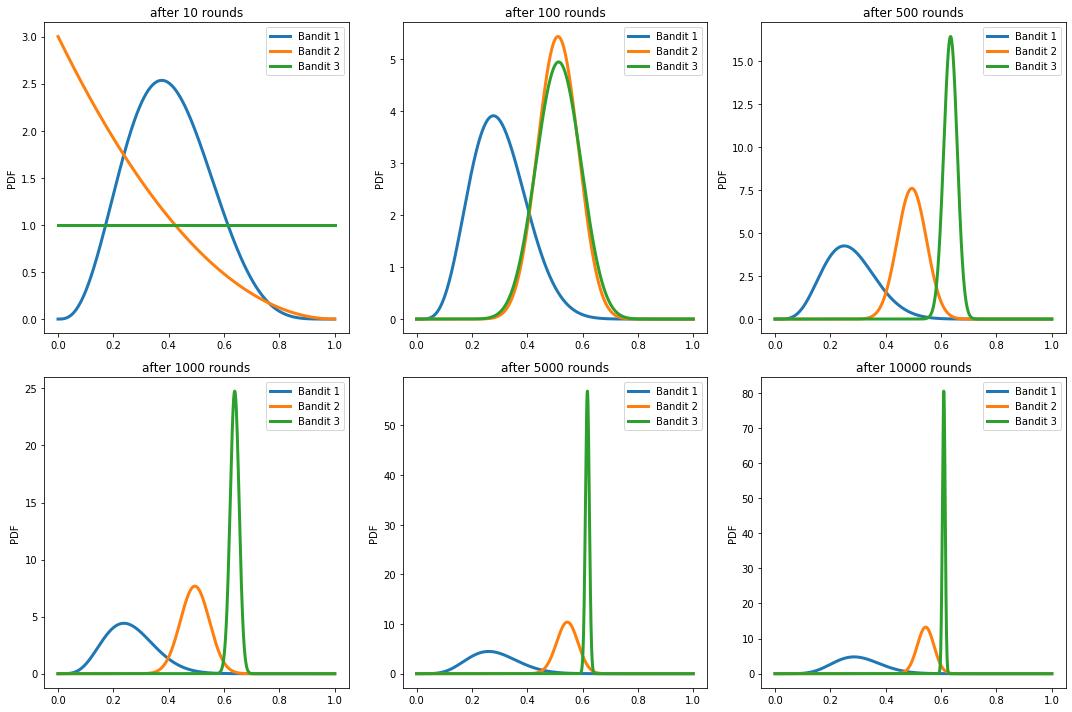

In [16]:
# Stuff for ploting 
fig, axs = plt.subplots(2,3, figsize= (15,10))
x = np.linspace(0,1,1000)
plot_counter = 0

# Known probability of pay out for each webpage (need this for simulation)
true_p = [0.4, 0.5, 0.6]

# function that simulated trying out one of the three webpages -- returns True if wins
def pull(i):
    return random.random() < true_p[i]

# initialize arrays which wil keep count of # of trials for each webpage and # of wins
wins = np.zeros(3)
trials = np.zeros(3)

for n in range(10000):
    
    # doing computation to decide which webpage to test 
    all_betas = stats.beta(1 + wins, 1 + trials - wins) # get posterior distribution for all bandits
    samples = all_betas.rvs()  # pull a sample from all posterior distributions
    choice = samples.argmax()  # choose the bandit with highest probability
    
    # testing webpage selected / updating wins and trials
    win = pull(choice)
    wins[choice] += win        # updating number of wins for each bandit 
    trials[choice] += 1        # updating number of trials of each bandit
    
    # make a plot after 9, 99, 999, and 49999 trials of probability of payout of each webpage
    if n in [9, 99, 499, 999, 4999,9999]:
        ax = axs.flatten()[plot_counter]
        for i in range(len(wins)):
            beta = stats.beta(1 + wins[i], 1 + trials[i] - wins[i])
            ax.plot(x, beta.pdf(x), 
                    label='Bandit {}'.format(i+1),
                    linewidth=3)
            ax.set_title('after {} rounds'.format(n + 1))
            ax.set_ylabel('PDF')
            ax.legend()
        plot_counter+=1
fig.tight_layout()

In [17]:
print(trials)

[  28.  272. 9700.]
